In [1]:
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import math
from functools import reduce
import random
import torch
%matplotlib inline
np.random.seed(42)

In [2]:
def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]
X_train, Y_train, X_test, Y_test = load()

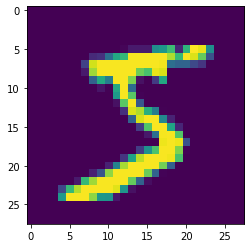

In [3]:
plt.imshow(X_train[0].reshape(28,28))

In [146]:
class Conv2d():
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.weight_size = (self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)
        self.stride = stride

        self.W = {'val': np.random.standard_normal(self.weight_size), 'grad': 0}
        self.b = {'val':  np.random.standard_normal((self.out_channels,1)), 'grad': 0}
        
        self.cache = None

    def forward(self, x):
        (N,C,H,W) = x.shape
        self.input_shape = x.shape
        H_out = (H - self.kernel_size) // self.stride + 1
        W_out = (W - self.kernel_size) // self.stride + 1
        conv_out = np.zeros((N, self.out_channels, H_out, W_out))
        self.col_image = []
        
        weight_cols = self.W['val'].reshape(self.out_channels, -1)
        for i in range(N):
            img_i = x[i][np.newaxis, :]
            x_cols = im2col(img_i, self.kernel_size, self.stride)
            conv_out[i] = (np.dot(weight_cols, x_cols.T) + self.b['val']).reshape(self.out_channels, H_out, W_out)
            self.col_image.append(x_cols)
        self.col_image = np.array(self.col_image)
        
        return conv_out
        
    def backward(self, error):
        (N,C,_,_) = error.shape
        error_col = error.reshape(N,C,-1)
        for i in range(N):
            self.W['grad'] += np.dot(error_col[i], self.col_image[i]).reshape(self.W['val'].shape)
        self.b['grad'] += np.sum(error_col, axis=(0,2)).reshape(self.b['val'].shape)
        
        error_pad =np.pad(error, ((0,0), (0,0), (self.kernel_size - 1, self.kernel_size - 1),
                          (self.kernel_size - 1, self.kernel_size - 1)), 'constant', constant_values=0)
        
        flip_weights = self.W['val'][:, :, ::-1, ::-1]
        flip_weights = flip_weights.swapaxes(0,1) # hard to make sure
        col_flip_weights = flip_weights.reshape(self.in_channels, -1)
        
        col_pad_delta = np.array([im2col(error_pad[i][np.newaxis, :], self.kernel_size, self.stride) for i in range(N)])
        next_delta = np.dot(col_pad_delta, col_flip_weights.T)
        print(next_delta.shape,next_delta.transpose(0,2,1).shape)
        next_delta = np.reshape(next_delta.transpose(0,2,1), self.input_shape)
        
        return next_delta

def im2col(image, kernel_size, stride):
    (N, C, H, W) = image.shape
    image_col = []
    for i in range(0, H - kernel_size + 1, stride):
        for j in range(0, W - kernel_size + 1, stride):
            col = image[:, :, i:i+kernel_size, j:j+kernel_size].reshape(-1)
            image_col.append(col)
    image_col = np.array(image_col)
    return image_col

def im2col_fast(image, kernel_size, stride):
    # Parameters
    N, C, H, W = image.shape
    H_out = (H - kernel_size) // stride + 1
    W_out = (W - kernel_size) // stride + 1
    shape = (N, C, H_out, W_out, kernel_size, kernel_size)
    strides = (*image.strides[:-2], image.strides[-2]*stride,
               image.strides[-1]*stride, *image.strides[-2:])

    out_view = np.lib.stride_tricks.as_strided(image, shape=shape, strides=stride)
    return out_view

In [179]:
def split_by_strides(X, kh, kw, s):
    N, C, H, W = X.shape
    oh = (H - kh) // s + 1
    ow = (W - kw) // s + 1
    strides = (*X.strides[:-2], X.strides[-2]*s, X.strides[-1]*s, *X.strides[-2:])
    A = np.lib.stride_tricks.as_strided(X, shape=(N,C,oh,ow,kh,kw), strides=strides)
    return A

In [180]:
w = np.arange(32).reshape(2,1,4,4)
w

array([[[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]]],


       [[[16, 17, 18, 19],
         [20, 21, 22, 23],
         [24, 25, 26, 27],
         [28, 29, 30, 31]]]])

In [181]:
im2col(w,2,1)

array([[ 0,  1,  4,  5, 16, 17, 20, 21],
       [ 1,  2,  5,  6, 17, 18, 21, 22],
       [ 2,  3,  6,  7, 18, 19, 22, 23],
       [ 4,  5,  8,  9, 20, 21, 24, 25],
       [ 5,  6,  9, 10, 21, 22, 25, 26],
       [ 6,  7, 10, 11, 22, 23, 26, 27],
       [ 8,  9, 12, 13, 24, 25, 28, 29],
       [ 9, 10, 13, 14, 25, 26, 29, 30],
       [10, 11, 14, 15, 26, 27, 30, 31]])

In [195]:
split_by_strides(w,2,2,1)

array([[[[ 0,  1,  4,  5,  1,  2,  5,  6,  2],
         [ 3,  6,  7,  4,  5,  8,  9,  5,  6],
         [ 9, 10,  6,  7, 10, 11,  8,  9, 12],
         [13,  9, 10, 13, 14, 10, 11, 14, 15]]],


       [[[16, 17, 20, 21, 17, 18, 21, 22, 18],
         [19, 22, 23, 20, 21, 24, 25, 21, 22],
         [25, 26, 22, 23, 26, 27, 24, 25, 28],
         [29, 25, 26, 29, 30, 26, 27, 30, 31]]]])

In [103]:
w[:, :, ::-1, ::-1].swapaxes(0,1).reshape(1,-1).shape

(1, 12)

In [131]:
img = np.arange(18).reshape(2,1,3,3)
img

array([[[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]]],


       [[[ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]]]])

In [132]:
conv = Conv2d(1,6,2)

In [133]:
out = conv.forward(img)
out


array([[[[  3.5902627 ,   8.12895827],
         [ 17.20634941,  21.74504498]],

        [[  1.88773956,   3.62287507],
         [  7.09314608,   8.82828159]],

        [[-13.09884549, -17.02165118],
         [-24.86726256, -28.79006825]],

        [[  4.58111275,   6.6057    ],
         [ 10.65487451,  12.67946176]],

        [[ -7.22630649,  -8.73672254],
         [-11.75755464, -13.26797069]],

        [[ -7.65071473,  -9.45590617],
         [-13.06628904, -14.87148048]]],


       [[[ 44.43852283,  48.9772184 ],
         [ 58.05460954,  62.59330511]],

        [[ 17.50395912,  19.23909463],
         [ 22.70936564,  24.44450115]],

        [[-48.4040967 , -52.32690239],
         [-60.17251377, -64.09531946]],

        [[ 22.80239803,  24.82698529],
         [ 28.87615979,  30.90074705]],

        [[-20.82005095, -22.330467  ],
         [-25.3512991 , -26.86171515]],

        [[-23.89743768, -25.70262912],
         [-29.31301199, -31.11820343]]]])

In [134]:
y = out + 1
y

array([[[[  4.5902627 ,   9.12895827],
         [ 18.20634941,  22.74504498]],

        [[  2.88773956,   4.62287507],
         [  8.09314608,   9.82828159]],

        [[-12.09884549, -16.02165118],
         [-23.86726256, -27.79006825]],

        [[  5.58111275,   7.6057    ],
         [ 11.65487451,  13.67946176]],

        [[ -6.22630649,  -7.73672254],
         [-10.75755464, -12.26797069]],

        [[ -6.65071473,  -8.45590617],
         [-12.06628904, -13.87148048]]],


       [[[ 45.43852283,  49.9772184 ],
         [ 59.05460954,  63.59330511]],

        [[ 18.50395912,  20.23909463],
         [ 23.70936564,  25.44450115]],

        [[-47.4040967 , -51.32690239],
         [-59.17251377, -63.09531946]],

        [[ 23.80239803,  25.82698529],
         [ 29.87615979,  31.90074705]],

        [[-19.82005095, -21.330467  ],
         [-24.3512991 , -25.86171515]],

        [[-22.89743768, -24.70262912],
         [-28.31301199, -30.11820343]]]])

In [135]:
conv.backward(y - out)

(2, 9, 1) (2, 1, 9)


array([[[[ 5.50782252,  6.17780148,  0.66997896],
         [ 0.84220891,  1.06000515,  0.21779624],
         [-4.66561361, -5.11779633, -0.45218272]]],


       [[[ 5.50782252,  6.17780148,  0.66997896],
         [ 0.84220891,  1.06000515,  0.21779624],
         [-4.66561361, -5.11779633, -0.45218272]]]])

In [128]:
a = 0
a += np.sum((y-out).reshape(2,6,-1), axis=(0,2))
a

array([8., 8., 8., 8., 8., 8.])

In [28]:
conv.b['grad']

array([[8.],
       [8.],
       [8.],
       [8.],
       [8.],
       [8.]])